## Requirements

In [3]:
!pip install -q transformers datasets
!pip install evaluate
!pip install peft
!pip install accelerate -U
!pip install transformers[torch]
!pip install umap-learn
!pip install -U imbalanced-learn
!pip3 install Cython
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.5/289.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


## Import Libraries

In [4]:
import numpy as np
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt


from sklearn.utils import resample
from datasets import Features, Value, ClassLabel
from datasets import load_dataset
from datasets import Dataset

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

import torch
from peft import get_peft_model, LoraConfig, TaskType

import evaluate
from transformers import TrainingArguments, Trainer


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import wandb


## UDF

In [5]:
def mistral_preprocessing_function(examples):
    return mistral_tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)


def compute_metrics(eval_pred):
    # All metrics are already predefined in the HF `evaluate` package
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")
    f1_metric= evaluate.load("f1")
    accuracy_metric = evaluate.load("accuracy")

    logits, labels = eval_pred # eval_pred is the tuple of predictions and labels returned by the model
    predictions = np.argmax(logits, axis=-1)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    # The trainer is expecting a dictionary where the keys are the metrics names and the values are the scores.
    return {"precision": precision, "recall": recall, "f1-score": f1, 'accuracy': accuracy}


class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss() # weight=torch.tensor([neg_weights, pos_weights], device=model.device, dtype=logits.dtype)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss



def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def measure_model_performance(trainer, df_input, y_labels, labels_list):
    preds_output = trainer.predict(df_input)
    print(preds_output.metrics)
    y_preds = np.argmax(preds_output.predictions, axis=1)
    plot_confusion_matrix(y_preds, y_labels, labels_list)


# Variable Setup

In [6]:
MAX_LEN = 512
roberta_checkpoint = "roberta-large"
mistral_checkpoint = 'pblair-basis/Mistral-7B-v0.1' # "mistralai/Mistral-7B-v0.1"
llama_checkpoint = "NousResearch/Llama-2-7b-hf"

## Load Dataset

In [7]:
#### Data Preparation step.
#### input the final_preprocessed_df.csv file path here
filename = "https://media.githubusercontent.com/media/Branden-Kang/LLaMA-2/main/data/final_preprocessed_df2.csv"

df = pd.read_csv(filename)

<ipython-input-7-69d11f00406b>:5: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133678 entries, 0 to 133677
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   133678 non-null  object 
 1   subreddit                    133668 non-null  object 
 2   author                       133668 non-null  object 
 3   over_18                      133668 non-null  object 
 4   link_flair_text              19278 non-null   object 
 5   title                        133660 non-null  object 
 6   selftext                     133660 non-null  object 
 7   url                          133642 non-null  object 
 8   created_utc                  133656 non-null  object 
 9   title_with_selftext          133656 non-null  object 
 10  title_with_selftext_cleaned  133656 non-null  object 
 11  polarity                     133656 non-null  float64
 12  class_group                  133656 non-null  object 
dtyp

In [9]:
df.head(3)

,Unnamed: 0,subreddit,author,over_18,link_flair_text,title,selftext,url,created_utc,title_with_selftext,title_with_selftext_cleaned,polarity,class_group
0,141414,depression,[deleted],False,NaN,"I've been chronically depressed for 4 years, n...","First of all, it's impossible to begin the sto...",http://www.reddit.com/r/depression/comments/2o...,2014-12-04 13:51:15,"I've been chronically depressed for 4 years, n...",chronically depressed year getting worse need...,-0.004304,Depression_Group
1,290280,depression,bbybroccoli,False,NaN,Has anyone had bad side effects on Wellbutrin ...,"I just started it last Wednesday, 150 mg in th...",https://www.reddit.com/r/depression/comments/4...,2016-08-22 15:12:43,Has anyone had bad side effects on Wellbutrin ...,anyone bad side effect wellbutrin bupropion ...,0.154464,Depression_Group
2,255110,depression,onlyindarkness,False,NaN,I want to live at the hospital.,The therapist I met with Friday afternoon aske...,https://www.reddit.com/r/depression/comments/4...,2016-04-17 02:03:20,I want to live at the hospital. The therapist ...,want live hospital therapist met friday after...,0.037710,Depression_Group


## Data Pre-processing

In [10]:
#### Pre-processing Step 0. Build dataframe for modeling : select only necessary features
df_pre = df[['title_with_selftext_cleaned','class_group']]
df_pre.columns = ['text','label_str']

#### Missing balue treatment & label creation
df_pre = df_pre.dropna(subset='label_str')
df_pre['label'] = df_pre.label_str.map({
    'Depression_Group': 0,
    'Neutral_Group': 1,
    'Happy_Group': 2,
})
df_pre = df_pre[['text','label']]

#### Modeling Data Preparation & sampling
df_depression = df_pre[df_pre.label==0]
df_neutral = df_pre[df_pre.label==1]
df_happy = df_pre[df_pre.label==2]


df_depression_sampled = resample(df_depression, replace=True, n_samples=10000, random_state=42) # reproducible results
df_neutral_sampled = resample(df_neutral, replace=True, n_samples=10000, random_state=42) # reproducible results
df_happy_sampled = resample(df_happy, replace=True, n_samples=10000, random_state=42) # reproducible results
df_sampled = pd.concat([df_depression_sampled, df_neutral_sampled, df_happy_sampled])

In [11]:
#### Dataset Split (train / validation / test) : 75% / 15% / 10 % respectively
df_train_dataset, df_validation_dataset, df_test_dataset =\
  np.split(df_sampled.sample(frac=1, random_state=42), [int(.75*len(df_sampled)), int(.9*len(df_sampled))])

###### Check the train/ validation / test count after the split
print(f'train data size : {len(df_train_dataset)}')
print(f'validation data size : {len(df_validation_dataset)}')
print(f'test data size : {len(df_test_dataset)}')

###### Save it as csv for load
df_train_dataset.to_csv('train_dataset.csv', index=False)
df_validation_dataset.to_csv('validation_dataset.csv', index=False)
df_test_dataset.to_csv('test_dataset.csv', index=False)



###### Formatted data as 'DatasetDict' type for the further modeling step
class_names = ["Depression_Group", "Neutral_Group", "Happy_Group"]
sentiment_features = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)}) ### feature maping from integer to class
file_dict = {'train': 'train_dataset.csv',
             'validation':'validation_dataset.csv',
             'test': 'test_dataset.csv'}
dataset = load_dataset('csv', data_files=file_dict, delimiter=",", column_names=['text', 'label'], features=sentiment_features, skiprows=1)

train data size : 22500
validation data size : 4500
test data size : 3000


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [12]:
# Split the dataset into training and validation datasets
data = dataset['train'].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
data['val'] = data.pop("test")
# Convert the test dataframe to HuggingFace dataset and add it into the first dataset
data['test'] = dataset['test']

In [13]:
data['train'].to_pandas().info()
data['test'].to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   label   18000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [14]:
# Number of Characters
max_char = data['train'].to_pandas()['text'].str.len().max()
# Number of Words
max_words = data['train'].to_pandas()['text'].str.split().str.len().max()

In [15]:
###### example case check
data['train'][0]

{'text': 'failure embarrassment seen  party last night half hour girl thought chemistry turn  chat like past time spoken spark gone first met  blown chance coward past month began realize blown chance finally confirmed last night party seen thought left overhear someone say another room jerking friend friend know surprised honest feel changed since first met  become loser literally self esteem confidence opposed used like opposite stated also tried pick speaking another girl likely also interested become like friend wishing would shut go away hoping someone else would replace left subconsciously entered self destruct mode started trying drown sorrow led vomit usually drink much went overboard try make feel betterto honest think continue living like much longer nothing ever going get better  never way used  never happy  girl would ever want hook loser like ',
 'label': 0}

## Modeling

In [16]:
#### Load Mistral 7B Tokenizer
###### Add prefix space to tokenize words into subwords
mistral_tokenizer = AutoTokenizer.from_pretrained(mistral_checkpoint,  add_prefix_space=True)
mistral_tokenizer.pad_token_id = mistral_tokenizer.eos_token_id
mistral_tokenizer.pad_token = mistral_tokenizer.eos_token

mistral_tokenized_datasets = data.map(mistral_preprocessing_function, batched=False)
# mistral_tokenized_datasets = mistral_tokenized_datasets.remove_columns(col_to_delete)
# mistral_tokenized_datasets = mistral_tokenized_datasets.rename_column("target", "label")
mistral_tokenized_datasets.set_format("torch")

###### Data collator for padding a batch of examples to the maximum length seen in the batch
mistral_data_collator = DataCollatorWithPadding(tokenizer=mistral_tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/969 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [17]:
# Load a pre-trained model with a sequence classification header
mistral_model =  AutoModelForSequenceClassification.from_pretrained(
  pretrained_model_name_or_path=mistral_checkpoint,
  num_labels=3,
  device_map="auto"
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at pblair-basis/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# ######  Lora configuration step

# mistral_model.config.pad_token_id = mistral_model.config.eos_token_id

# mistral_peft_config = LoraConfig(
#     task_type=TaskType.SEQ_CLS, r=2, lora_alpha=16, lora_dropout=0.1, bias="none",
#     target_modules=[
#         "q_proj",
#         "v_proj",
#     ],
# )

# mistral_model = get_peft_model(mistral_model, mistral_peft_config)
# mistral_model.print_trainable_parameters()

trainable params: 864,256 || all params: 7,111,536,640 || trainable%: 0.012152872772093318

## Hyperparameter tuning (wandb)

In [19]:
wandb.login() # After signing up for wandb, you must enter the API

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define sweep config
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    # 'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'metric': {'goal': 'minimize', 'name': 'val_loss'},
    'parameters':
    {
        'batch_size': {'values': [3, 6, 9]},
        'epochs': {'values': [5, 10, 15]},
        'lr': {'max': 2e-04, 'min': 1e-05},
        'lora_rank': {'values': [4, 8, 16, 32]},
        'lora_alpha': {'values': [16, 32, 64]},
        'lora_dropout': {'max': 0.1, 'min': 0.0}
     }
}

###### model parameter setting
mistral_model = mistral_model.cuda()

# Initialize sweep by passing in config. (Optional) Provide a name of the project.
sweep_id = wandb.sweep(sweep=sweep_configuration, project='my-mistral-sweep')

def main():
    run = wandb.init()

    # note that we define values from `wandb.config` instead
    # of defining hard values
    lr  =  wandb.config.lr
    bs = wandb.config.batch_size
    epochs = wandb.config.epochs

    lora_rank_=wandb.config.lora_rank
    lora_alpha_= wandb.config.lora_alpha
    lora_dropout_= wandb.config.lora_dropout

    ######  Lora configuration step

    global mistral_model

    mistral_model.config.pad_token_id = mistral_model.config.eos_token_id

    mistral_peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=2, lora_alpha=16, lora_dropout=0.1, bias="none",
        target_modules=[
            "q_proj",
            "v_proj",
        ],
    )

    mistral_model = get_peft_model(mistral_model, mistral_peft_config)
    mistral_model.print_trainable_parameters()

    for epoch in np.arange(1, epochs):
        training_args = TrainingArguments(
            output_dir="mistral-lora-token-classification",
            learning_rate=lr,
            lr_scheduler_type= "constant",
            warmup_ratio= 0.1,
            max_grad_norm= 0.3,
            per_device_train_batch_size=bs,
            per_device_eval_batch_size=bs,
            num_train_epochs=epoch,
            weight_decay=0.001,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            report_to="wandb",
            fp16=True,
            gradient_checkpointing=True,
        )

        mistral_trainer = WeightedCELossTrainer(
            model=mistral_model,
            args=training_args,
            train_dataset=mistral_tokenized_datasets['train'],
            eval_dataset=mistral_tokenized_datasets["val"],
            data_collator=mistral_data_collator,
            compute_metrics=compute_metrics
        )

        mistral_trainer.train()

# Start sweep job.
wandb.agent(sweep_id, function=main, count=4) # entity='username', 'project='my-project'

In [ ]:
api = wandb.Api()

sweep = api.sweep(f"kangsy413/my-llama2-sweep/sweeps/{sweep-id}") # kangsy413: entity name / my-first-sweep: project-name
# sweep = api.sweep("entity/project-name/sweeps/sweep-id")

# Get best run parameters
best_run = sweep.best_run(order='val_loss')
# best_run = sweep.best_run(order='validation/accuracy')
best_parameters = best_run.config
print(best_parameters)

In [ ]:
######  Lora configuration step
mistral_model.config.pad_token_id = mistral_model.config.eos_token_id

mistral_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=best_parameters['lr'], lora_alpha=best_parameters['lr'], lora_dropout=best_parameters['lr'], bias="none",
    target_modules=[
        "q_proj",
        "v_proj",
    ],
)

mistral_model = get_peft_model(mistral_model, mistral_peft_config)
mistral_model.print_trainable_parameters()

In [ ]:
###### model parameter setting
mistral_model = mistral_model.cuda()

lr = best_parameters['lr']
batch_size = best_parameters['batch_size']
num_epochs = best_parameters['epochs']

training_args = TrainingArguments(
    output_dir="mistral-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # report_to="wandb",
    fp16=True,
    gradient_checkpointing=True,
)


mistral_trainer = WeightedCELossTrainer(
    model=mistral_model,
    args=training_args,
    train_dataset=mistral_tokenized_datasets['train'],
    eval_dataset=mistral_tokenized_datasets["val"],
    data_collator=mistral_data_collator,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
mistral_trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.335800,0.361038,0.941778,0.941904
2,0.279700,0.318474,0.951111,0.950980


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarni

TrainOutput(global_step=4500, training_loss=0.39702144029405384, metrics={'train_runtime': 1504.5547, 'train_samples_per_second': 23.927, 'train_steps_per_second': 2.991, 'total_flos': 4.524865620197376e+17, 'train_loss': 0.39702144029405384, 'epoch': 2.0})

In [ ]:
####### evaluation metrics
metrics = mistral_trainer.evaluate(eval_dataset=mistral_tokenized_datasets["val"])
print(metrics)

{'eval_loss': 0.3184742331504822, 'eval_accuracy': 0.9511111111111111, 'eval_f1': 0.9509800137802857, 'eval_runtime': 139.6826, 'eval_samples_per_second': 32.216, 'eval_steps_per_second': 4.031, 'epoch': 2.0}


In [ ]:
# Save trained model and tokenizer
mistral_trainer.save_model()
mistral_tokenizer.save_pretrained("mistral-lora-token-classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('mistral-lora-token-classification/tokenizer_config.json',
 'mistral-lora-token-classification/special_tokens_map.json',
 'mistral-lora-token-classification/tokenizer.model',
 'mistral-lora-token-classification/added_tokens.json',
 'mistral-lora-token-classification/tokenizer.json')

{'test_loss': 0.3184742331504822, 'test_accuracy': 0.9511111111111111, 'test_f1': 0.9509800137802857, 'test_runtime': 139.703, 'test_samples_per_second': 32.211, 'test_steps_per_second': 4.03}


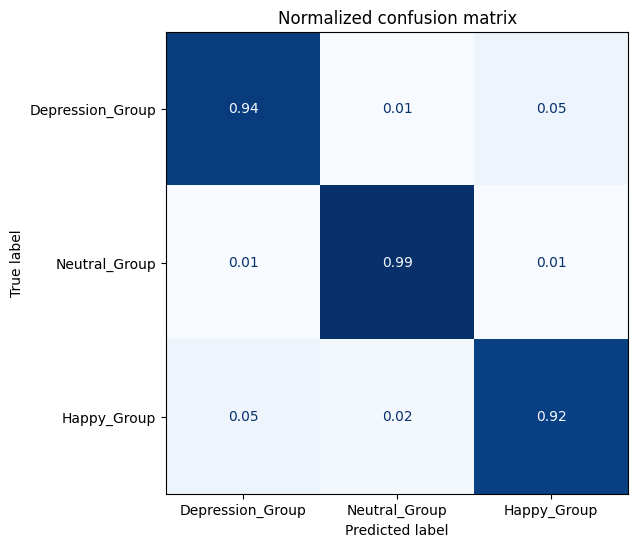

In [ ]:
#### Model evaluation Confuxion matrix
labels_names_list = dataset['train'].features['label'].names

###### validation set
measure_model_performance(mistral_trainer, mistral_tokenized_datasets["val"], mistral_tokenized_datasets["val"]['label'], labels_names_list)

{'test_loss': 0.2952467203140259, 'test_accuracy': 0.9463333333333334, 'test_f1': 0.9462240477988143, 'test_runtime': 90.8712, 'test_samples_per_second': 33.014, 'test_steps_per_second': 4.127}


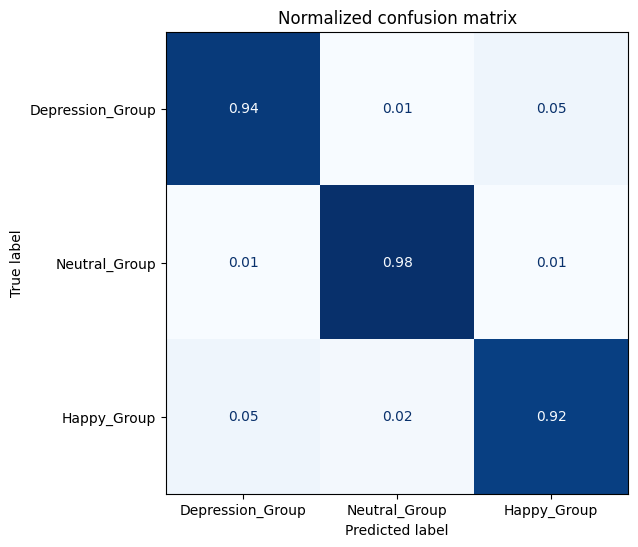

In [ ]:
###### test set
measure_model_performance(mistral_trainer, mistral_tokenized_datasets["test"], mistral_tokenized_datasets["test"]['label'], labels_names_list)

In [ ]:
# # # Save the model and tokenizer
# # trainer.model.save_pretrained(new_model)
# # trainer.tokenizer.save_pretrained(new_model)

# from peft import LoraConfig, PeftModel

# print("Loading PEFT model")
# model = PeftModel.from_pretrained(mistral_model, "mistral-lora-token-classification")
# print(f"Running merge_and_unload")
# model = model.merge_and_unload()

# tokenizer = AutoTokenizer.from_pretrained(mistral_checkpoint)

# merged_model = "mistral-lora-token-classification/merged"
# model.save_pretrained(merged_model)
# tokenizer.save_pretrained(merged_model)
# print(f"Model saved to {merged_model}")

In [ ]:
# from peft import AutoPeftModelForSequenceClassification
# from transformers import AutoTokenizer

## Model Evaluation Demo

In [ ]:
###### Define classifier
labels_names_list = dataset['train'].features['label'].names
classifier = pipeline("text-classification", model=mistral_model.model, tokenizer=mistral_tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


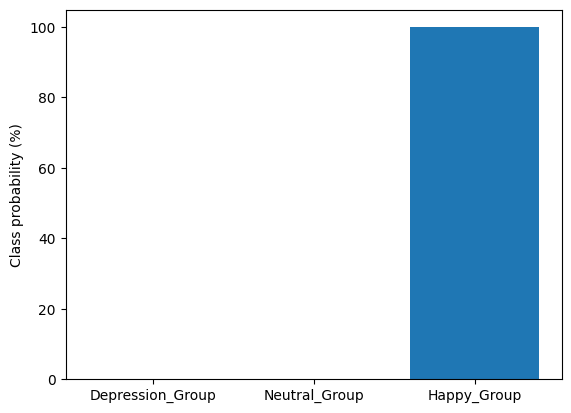

Visually stunning with some amazing battle scenes but it did have major pacing issues, especially in the first half. Also there was practically zero context given for like half the stuff that happened.


In [ ]:
custom_tweet = "Visually stunning with some amazing battle scenes but it did have major pacing issues, especially in the first half. Also there was practically zero context given for like half the stuff that happened."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

I failed my NLP exam yesterday and was really sad and didn't know what to do.I thought like life really sucks but today I met my best friend and he encouraged me and cheered me up to overcome this hardship. Because of his support I am not sad anymore and exam is just exam and it will be fine.


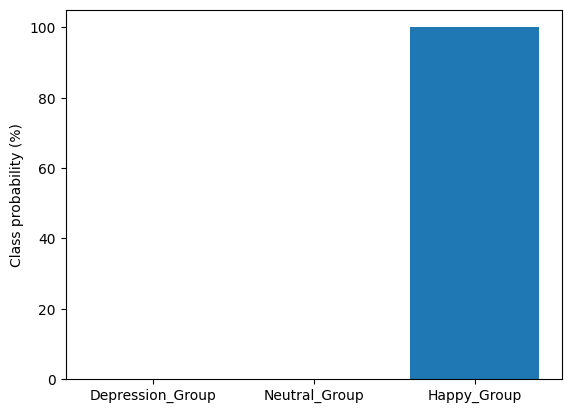

In [ ]:
custom_tweet = custom_tweet = "I failed my NLP exam yesterday and was really sad and didn't know what to do.\
I thought like life really sucks but today I met my best friend and he encouraged me and cheered me up to overcome this hardship. \
Because of his support I am not sad anymore and exam is just exam and it will be fine."
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Although there are times when I feel down at school, there are also moments of pure happiness that brighten my day.    It's like discovering unexpected joy in the midst of challenges, reminding me that happiness can be found even in the smallest of moments.


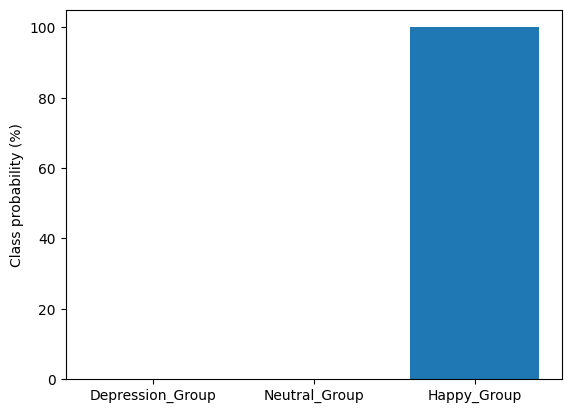

In [ ]:
custom_tweet = "Although there are times when I feel down at school, there are also moments of pure happiness that brighten my day.\
    It's like discovering unexpected joy in the midst of challenges, reminding me that happiness can be found even in the smallest of moments."
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Even when I'm in school, with friends and activities around, the feeling of happiness is weak compared to the sadness I often feel.    It's like trying to find a small spark of joy in a big storm of gloominess. Despite the efforts to cheer up, the weight of sadness seems to always linger.    It's like feeling a little bit of sunshine on a cloudy day, but the clouds never really go away.     Even with school life bustling around, the feeling of sadness is still there, making it hard to fully enjoy the moment.


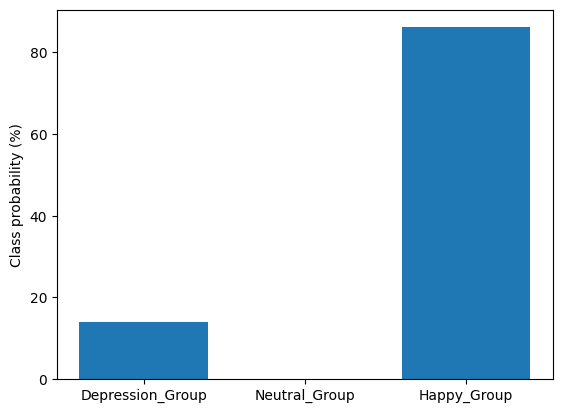

In [ ]:
custom_tweet = "Even when I'm in school, with friends and activities around, the feeling of happiness is weak compared to the sadness I often feel. \
   It's like trying to find a small spark of joy in a big storm of gloominess. Despite the efforts to cheer up, the weight of sadness seems to always linger.\
    It's like feeling a little bit of sunshine on a cloudy day, but the clouds never really go away. \
    Even with school life bustling around, the feeling of sadness is still there, making it hard to fully enjoy the moment."
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

## Custom dataset test

## Depression

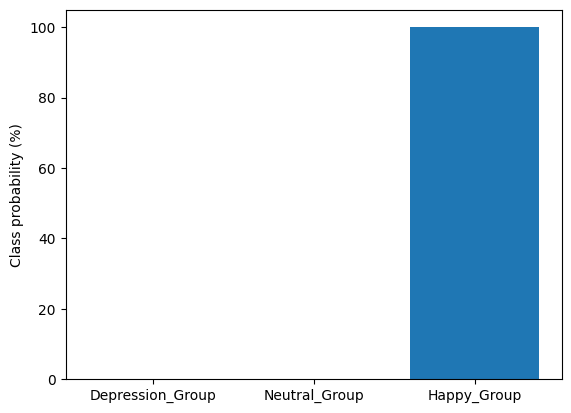

,0,1,2
label,LABEL_0,LABEL_1,LABEL_2
score,0.000065,0.0,0.999935


In [ ]:
custom_tweet = \
"Even though the halls are filled with laughter and chatter, there's this feeling weighing on me.\
It's like riding the wave of excitement while also carrying a bit of sadness, a reminder that life isn't always sunshine and rainbows.\
Despite the energy around me, there's a cloud in my mind, making everything seem a bit less bright.\
It's a mix of happy and sad, like a seesaw where neither side is quite up or down. \
But I still hold onto hope, believing things will get better, even if they're a bit uncertain right now."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
preds_df.transpose()

During school days, there are moments when I feel a sense of happiness, perhaps when I receive praise from a teacher or when I achieve a personal goal. However, underlying that happiness, there's often a deeper feeling of despair, like when I struggle to keep up with my classmates or when I feel isolated in a crowd. Even though there are moments of joy, the weight of hopelessness seems to overshadow them, leaving me feeling more alone than ever.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


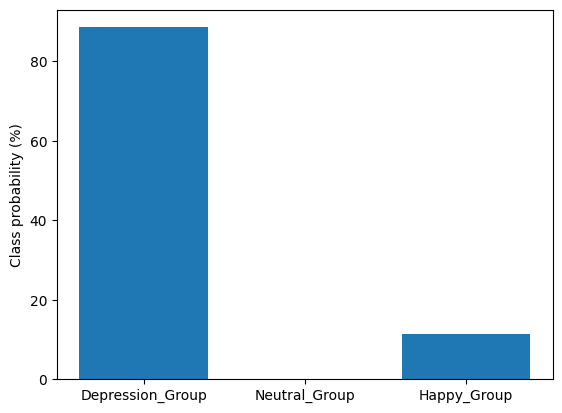

In [ ]:
custom_tweet = "During school days, there are moments when I feel a sense of happiness, perhaps when I receive praise from a teacher or when I achieve a personal goal. \
However, underlying that happiness, there's often a deeper feeling of despair, like when I struggle to keep up with my classmates or when I feel isolated in a crowd. \
Even though there are moments of joy, the weight of hopelessness seems to overshadow them, leaving me feeling more alone than ever."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

When I experience moments of contentment, such as when I finish a project ahead of schedule or receive positive feedback from a colleague.Yet, despite these brief moments of happiness, there's a persistent sense of emptiness that lingers, stemming from feelings of insecurity or dissatisfaction with my career. Despite my efforts to focus on the positives, the feeling of despair remains, making it difficult to fully enjoy the successes I achieve.


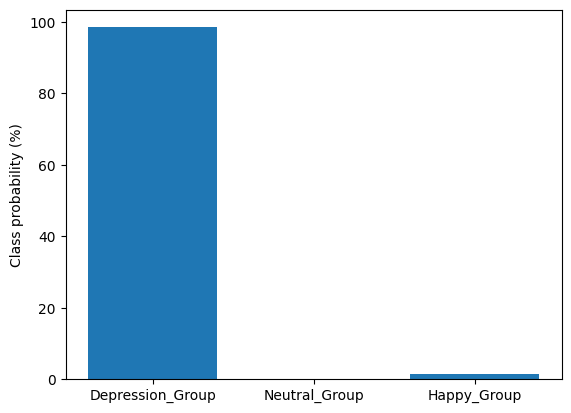

In [ ]:
custom_tweet = "When I experience moments of contentment, such as when I finish a project ahead of schedule or receive positive feedback from a colleague.\
Yet, despite these brief moments of happiness, there's a persistent sense of emptiness that lingers, stemming from feelings of insecurity or dissatisfaction with my career. \
Despite my efforts to focus on the positives, the feeling of despair remains, making it difficult to fully enjoy the successes I achieve."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Within my family, there are times when I share moments of laughter and love with my loved ones, cherishing the bonds we share.However, amidst these moments of happiness, there's an underlying feeling of sorrow that I can't seem to shake off, stemming from unresolved conflicts or distant relationships. Despite the warmth of family connections, the weight of melancholy prevails, casting a shadow over our interactions and leaving me yearning for deeper connection and understanding.


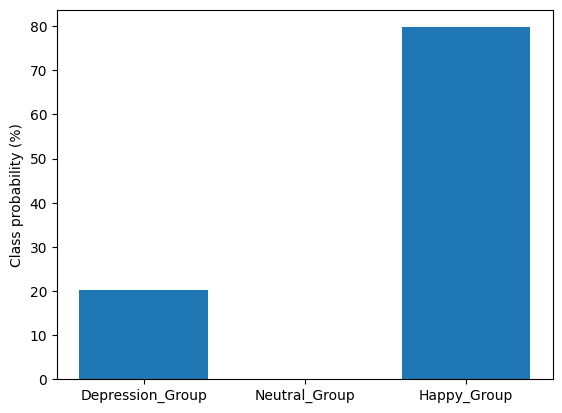

In [ ]:
custom_tweet = "Within my family, there are times when I share moments of laughter and love with my loved ones, cherishing the bonds we share.\
However, amidst these moments of happiness, there's an underlying feeling of sorrow that I can't seem to shake off, stemming from unresolved conflicts or distant relationships. \
Despite the warmth of family connections, the weight of melancholy prevails, casting a shadow over our interactions and leaving me yearning for deeper connection and understanding."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Even on a lively school day, amidst the laughter and chatter of friends, there's a quiet ache in my heart. It's like being part of the joy while carrying a hidden weight, a faint feeling of emptiness that mutes the excitement, reminding me that even in the midst of happiness, there's a subtle shadow.


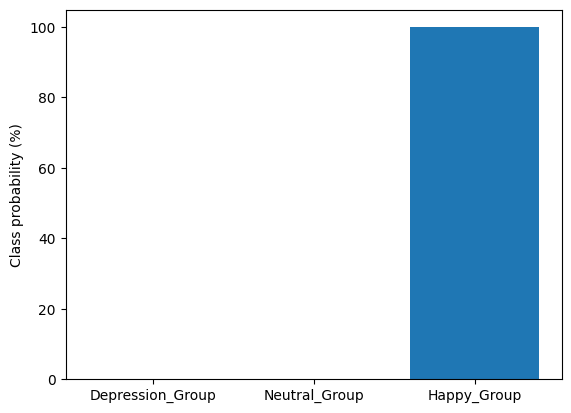

In [ ]:
custom_tweet = custom_tweet = \
"Even on a lively school day, amidst the laughter and chatter of friends, there's a quiet ache in my heart. It's like being part of the joy while carrying a hidden weight, \
a faint feeling of emptiness that mutes the excitement, reminding me that even in the midst of happiness, there's a subtle shadow."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Even though the halls are filled with laughter and chatter, there's this feeling weighing on me.It's like riding the wave of excitement while also carrying a bit of sadness, a reminder that life isn't always sunshine and rainbows.Despite the energy around me, there's a cloud in my mind, making everything seem a bit less bright.It's a mix of happy and sad, like a seesaw where neither side is quite up or down. But I still hold onto hope, believing things will get better, even if they're a bit uncertain right now.


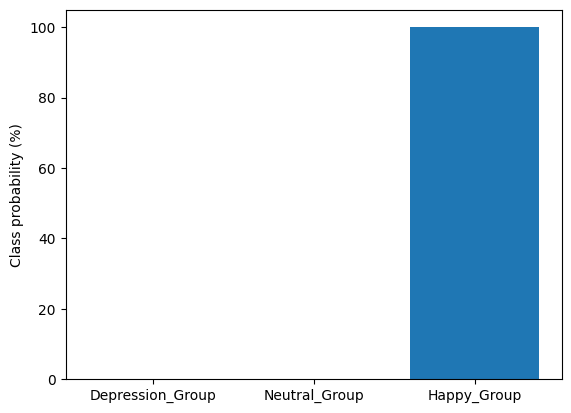

In [ ]:
custom_tweet = "Even though the halls are filled with laughter and chatter, there's this feeling weighing on me.\
It's like riding the wave of excitement while also carrying a bit of sadness, a reminder that life isn't always sunshine and rainbows.\
Despite the energy around me, there's a cloud in my mind, making everything seem a bit less bright.\
It's a mix of happy and sad, like a seesaw where neither side is quite up or down. \
But I still hold onto hope, believing things will get better, even if they're a bit uncertain right now."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

## Happy

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


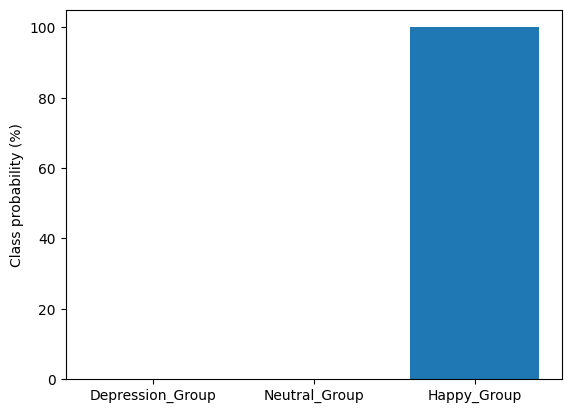

,0,1,2
label,LABEL_0,LABEL_1,LABEL_2
score,0.0,0.0,1.0


In [ ]:
custom_tweet = \
"During school days, there are moments when I feel down, maybe because of a bad grade or a disagreement with a friend. \
But amidst those gloomy times, there are also moments of happiness, like when I solve a problem I've been struggling with\
or when I share a laugh with my classmates. Even though the sad moments weigh on me, the happiness I feel is a bit stronger.\
It's like finding a small flower blooming in the midst of a barren field, a tiny glimmer of light in the darkness. \
Despite the challenges, those moments of joy keep me going, reminding me that there's always something to smile about,\
even in the toughest of times."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
preds_df.transpose()

During school days, there are moments when I feel down, maybe because of a bad grade or a disagreement with a friend. But amidst those gloomy times, there are also moments of happiness, like when I solve a problem I've been struggling with or when I share a laugh with my classmates. Even though the sad moments weigh on me, the happiness I feel is a bit stronger. It's like finding a small flower blooming in the midst of a barren field, a tiny glimmer of light in the darkness. Despite the challenges, those moments of joy keep me going, reminding me that there's always something to smile about, even in the toughest of times.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


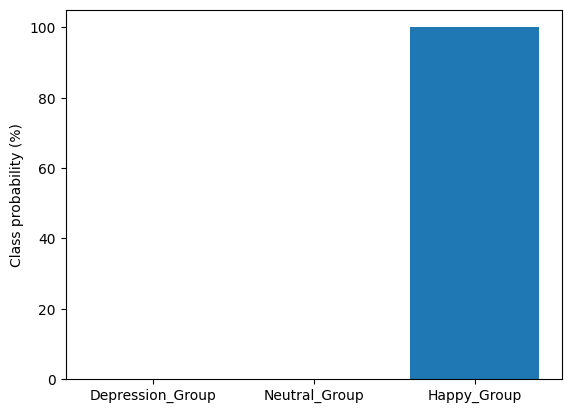

In [ ]:
custom_tweet =  "During school days, there are moments when I feel down, maybe because of a bad grade or a disagreement with a friend. \
But amidst those gloomy times, there are also moments of happiness, like when I solve a problem I've been struggling with or when I share a laugh with my classmates. \
Even though the sad moments weigh on me, the happiness I feel is a bit stronger. It's like finding a small flower blooming in the midst of a barren field, a tiny glimmer of light in the darkness. \
Despite the challenges, those moments of joy keep me going, reminding me that there's always something to smile about, even in the toughest of times."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

During family gatherings, there are occasions when tensions run high, perhaps due to disagreements or unresolved conflicts. But amid the occasional conflicts, there are also moments of happiness, like when we share stories and laughter around the dinner table or reminisce about fond memories. Even though arguments may arise, the warmth of family bonds prevails. It's like finding harmony in the midst of discord, a glimmer of love amidst the strife. Despite the occasional disagreements, those moments of connection keep us united, reminding us of the strength of family ties.


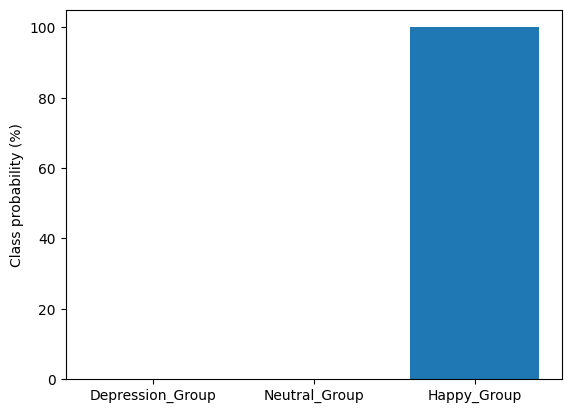

In [ ]:
custom_tweet =  "During family gatherings, there are occasions when tensions run high, perhaps due to disagreements or unresolved conflicts. \
But amid the occasional conflicts, there are also moments of happiness, like when we share stories and laughter around the dinner table or reminisce about fond memories. \
Even though arguments may arise, the warmth of family bonds prevails. It's like finding harmony in the midst of discord, a glimmer of love amidst the strife. \
Despite the occasional disagreements, those moments of connection keep us united, reminding us of the strength of family ties."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

In [ ]:
custom_tweet =  "At work, there are days when I feel overwhelmed, especially when deadlines are looming or when I face criticism from my boss. \
But in the midst of those stressful times, there are also moments of happiness, like when I successfully complete a project or receive recognition for my hard work. \
Even though the pressure gets to me, the joy of accomplishment outweighs the stress. It's like finding a silver lining in a stormy sky, a brief moment of relief amidst the chaos. \
Despite the challenges, those small victories keep me motivated, reminding me that perseverance pays off."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

## Neutral

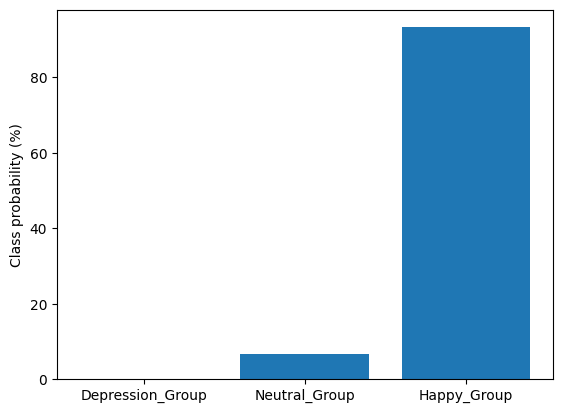

,0,1,2
label,LABEL_0,LABEL_1,LABEL_2
score,0.000035,0.067287,0.932678


In [ ]:
custom_tweet = \
"In the latest quarterly report, the company announced steady growth in revenue and market share,\
signaling stability in the face of economic uncertainty.However, analysts caution against complacency,\
highlighting potential challenges in the competitive landscape and evolving consumer preferences. \
Despite the cautious outlook, the company remains optimistic about its prospects for future growth."

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
preds_df.transpose()

Recent studies suggest that the new policy implemented by the government has elicited a mixed response from experts in the field. While some argue for its potential benefits in addressing socioeconomic disparities, others remain skeptical, citing potential unintended consequences. Despite the divergent opinions, further research is needed to assess the long-term implications of this policy shift.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


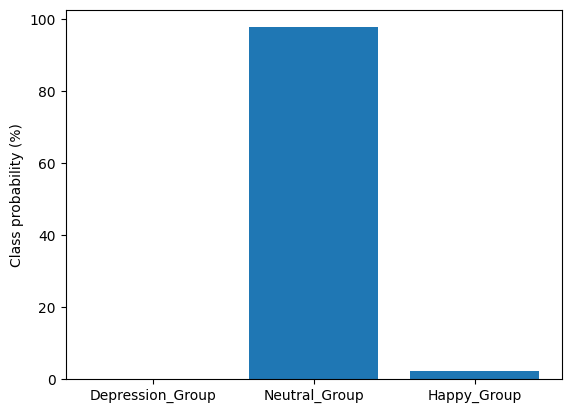

In [ ]:
custom_tweet =  "Recent studies suggest that the new policy implemented by the government has elicited a mixed response from experts in the field. While some argue for its potential benefits in addressing socioeconomic disparities, others remain skeptical, citing potential unintended consequences. Despite the divergent opinions, further research is needed to assess the long-term implications of this policy shift."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

In the latest quarterly report, the company announced steady growth in revenue and market share, signaling stability in the face of economic uncertainty. However, analysts caution against complacency, highlighting potential challenges in the competitive landscape and evolving consumer preferences. Despite the cautious outlook, the company remains optimistic about its prospects for future growth.


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


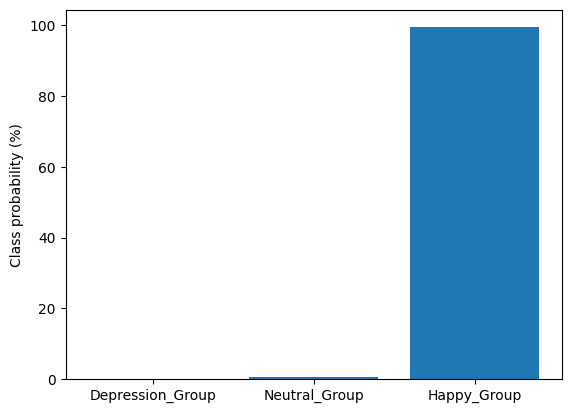

In [ ]:
custom_tweet =  "In the latest quarterly report, the company announced steady growth in revenue and market share, signaling stability in the face of economic uncertainty. However, analysts caution against complacency, highlighting potential challenges in the competitive landscape and evolving consumer preferences. Despite the cautious outlook, the company remains optimistic about its prospects for future growth."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

The findings from the survey reveal a nuanced perspective on the issue, with respondents expressing a range of viewpoints. While some respondents voiced support for the proposed initiative, others expressed reservations, citing concerns about feasibility and implementation challenges. Despite the differing opinions, there is consensus on the need for further dialogue and collaboration to address the complex issues at hand.


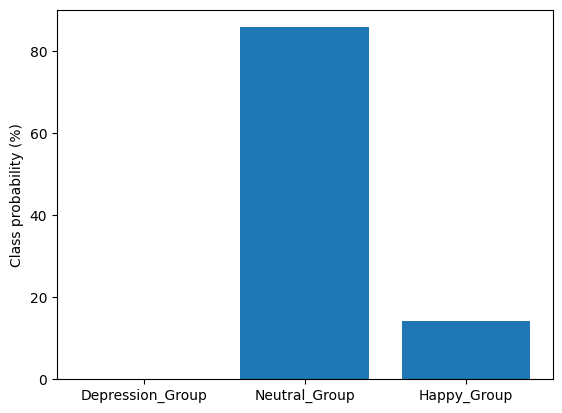

In [ ]:
custom_tweet = "The findings from the survey reveal a nuanced perspective on the issue, with respondents expressing a range of viewpoints. While some respondents voiced support for the proposed initiative, others expressed reservations, citing concerns about feasibility and implementation challenges. Despite the differing opinions, there is consensus on the need for further dialogue and collaboration to address the complex issues at hand."

print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()